# Student Stress EDA using TFDV and Prediction

## Download Dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("steve1215rogg/student-lifestyle-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/steve1215rogg/student-lifestyle-dataset/versions/1


In [2]:
!ls /root/.cache/kagglehub/datasets/steve1215rogg/student-lifestyle-dataset/versions/1

student_lifestyle_dataset.csv


## Import Dependencies

In [3]:
import pandas as pd
import tensorflow as tf
import tensorflow_data_validation as tfdv
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score


2024-11-12 01:41:39.987106: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-12 01:41:40.116112: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-12 01:41:40.175458: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-12 01:41:40.175555: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-12 01:41:40.245369: I tensorflow/core/platform/cpu_feature_gua

### Load DF

In [4]:
df = pd.read_csv(path + "/student_lifestyle_dataset.csv")
df.head()

,Student_ID,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day,GPA,Stress_Level
0,1,6.9,3.8,8.7,2.8,1.8,2.99,Moderate
1,2,5.3,3.5,8.0,4.2,3.0,2.75,Low
2,3,5.1,3.9,9.2,1.2,4.6,2.67,Low
3,4,6.5,2.1,7.2,1.7,6.5,2.88,Moderate
4,5,8.1,0.6,6.5,2.2,6.6,3.51,High


### Count Stress Level values

In [5]:
df['Stress_Level'].value_counts()

High        1029
Moderate     674
Low          297
Name: Stress_Level, dtype: int64

### Encode Stress Level values

In [6]:
le = LabelEncoder()

df['Stress_Level'] = le.fit_transform(df['Stress_Level'])

# EDA

### Correlation Analysis

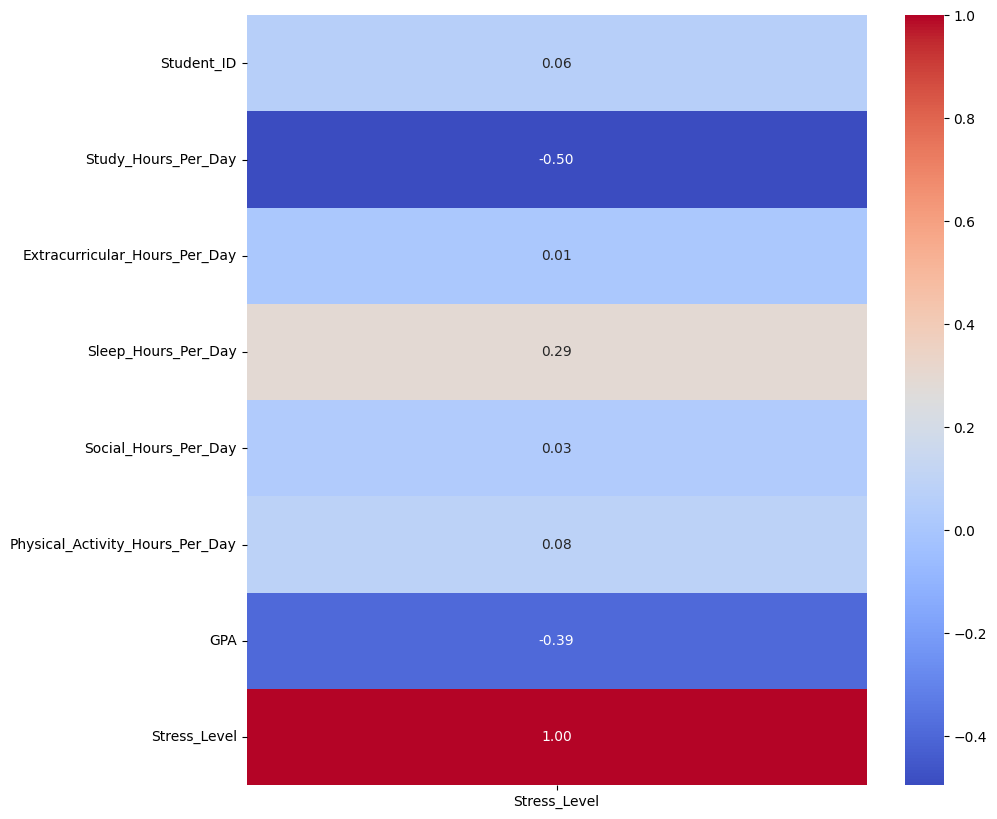

In [7]:
corr = df.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr[['Stress_Level']], annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

### Finding Outliers

In [8]:
# Calculate Z-scores
z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number])))

# Define a threshold for identifying outliers
threshold = 3

# Find outliers
outliers = np.where(z_scores > threshold)

# Print the indices of outliers
print("Indices of outliers:", outliers)

Indices of outliers: (array([  62,  171,  784, 1174]), array([5, 5, 5, 5]))


In [9]:
outlier_rows = df.iloc[outliers[0]]
outlier_rows

,Student_ID,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day,GPA,Stress_Level
62,63,5.1,0.5,5.2,0.2,13.0,2.85,0
171,172,5.1,0.3,6.0,0.2,12.4,2.70,1
784,785,5.1,0.3,6.3,0.2,12.1,2.55,1
1174,1175,5.3,0.3,5.9,0.2,12.3,2.97,0


#### Train Test Split DF

In [10]:
df.drop('Student_ID', axis=1, inplace=True)

In [11]:
X, TEST = train_test_split(df, test_size=0.2, random_state=42)
TEST, VAL = train_test_split(TEST, test_size=0.5, random_state=42)


## TFDV Analysis

In [12]:
# Generate statistics from DataFrames
train_stats = tfdv.generate_statistics_from_dataframe(X)
test_stats = tfdv.generate_statistics_from_dataframe(TEST)
val_stats = tfdv.generate_statistics_from_dataframe(VAL)
# Visualize statistics
tfdv.visualize_statistics(lhs_statistics=test_stats, rhs_statistics=train_stats,
                          lhs_name='TEST_DATASET', rhs_name='TRAIN_DATASET')

#### Finding anomalies

In [13]:
schema = tfdv.infer_schema(train_stats)
anomalies = tfdv.validate_statistics(statistics=test_stats, schema=schema)
tfdv.display_anomalies(anomalies)

In [14]:
schema = tfdv.infer_schema(train_stats)
anomalies = tfdv.validate_statistics(statistics=val_stats, schema=schema)
tfdv.display_anomalies(anomalies)

In [15]:
# Add skew comparator for 'PSS_score' feature.
Stress_Level = tfdv.get_feature(schema, 'Stress_Level')
Stress_Level.skew_comparator.infinity_norm.threshold = 0.01


# TODO
skew_anomalies = tfdv.validate_statistics(train_stats, schema,
                                          previous_statistics=test_stats,
                                          serving_statistics=val_stats)

tfdv.display_anomalies(skew_anomalies)

# Model

### Train - Y

In [16]:
X_train = X.drop('Stress_Level', axis=1)
y_train = X['Stress_Level']
X_test = TEST.drop('Stress_Level', axis=1)
y_test = TEST['Stress_Level']
X_val = VAL.drop('Stress_Level', axis=1)
y_val = VAL['Stress_Level']

#### One-hot encoding Y

In [17]:
enc = OneHotEncoder()
y_train_label = enc.fit_transform(y_train.values.reshape(-1, 1)).toarray()
y_test_label = enc.transform(y_test.values.reshape(-1, 1)).toarray()
y_val_label = enc.transform(y_val.values.reshape(-1, 1)).toarray()


In [18]:
print("Classes: ", le.classes_)
print("Categories: ", enc.categories_)

Classes:  ['High' 'Low' 'Moderate']
Categories:  [array([0, 1, 2])]


#### Creating Tensor Slices

In [19]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train_label))
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test_label))
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val_label))

2024-11-12 01:42:06.422923: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-12 01:42:06.756230: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-12 01:42:06.756863: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-12 01:42:06.766840: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-12 01:42:06.768902: I external/local_xla/xla/stream_executor

### Model definition

In [ ]:
model = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(y_train_label.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6),
             tf.keras.callbacks.ModelCheckpoint(filepath='b_model.keras', monitor='val_accuracy', save_best_only=True)]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,139 (168.51 KB)

 Trainable params: 43,139 (168.51 KB)

 Non-trainable params: 0 (0.00 B)

### Adapting tensor slices to Model

In [21]:
train_data_ep = train_data.map(lambda x, y: (tf.reshape(x, (1, X_train.shape[1])), tf.reshape(y, (1, y_train_label.shape[1])))).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_data_ep = val_data.map(lambda x, y: (tf.reshape(x, (1, X_val.shape[1])), tf.reshape(y, (1, y_train_label.shape[1])))).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### Model Fitting

In [22]:
history = model.fit(train_data_ep, epochs=20, validation_data=val_data_ep, callbacks=callbacks)

Epoch 1/20


I0000 00:00:1731386530.568304  322067 service.cc:145] XLA service 0x7fd364002f20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731386530.568463  322067 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-11-12 01:42:10.600347: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-12 01:42:10.767325: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8900


 122/1600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5005 - loss: 1.0149

I0000 00:00:1731386531.147276  322067 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1600/1600 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6918 - loss: 0.6480 - val_accuracy: 0.9050 - val_loss: 0.2316
Epoch 2/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8600 - loss: 0.3055 - val_accuracy: 0.8900 - val_loss: 0.2709
Epoch 3/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8850 - loss: 0.2730 - val_accuracy: 0.8750 - val_loss: 0.2966
Epoch 4/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8956 - loss: 0.2470 - val_accuracy: 0.8700 - val_loss: 0.3459
Epoch 5/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9079 - loss: 0.2371 - val_accuracy: 0.8450 - val_loss: 0.4233
Epoch 6/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9180 - loss: 0.2275 - val_accuracy: 0.8750 - val_loss: 0.3516
Epoch 7/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9239 - loss: 0.2067 - val_accuracy: 0.8600 - val_loss: 0.4010
Epoch 8/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9193 - loss: 0.1972 - val_accurac

### Plot model results

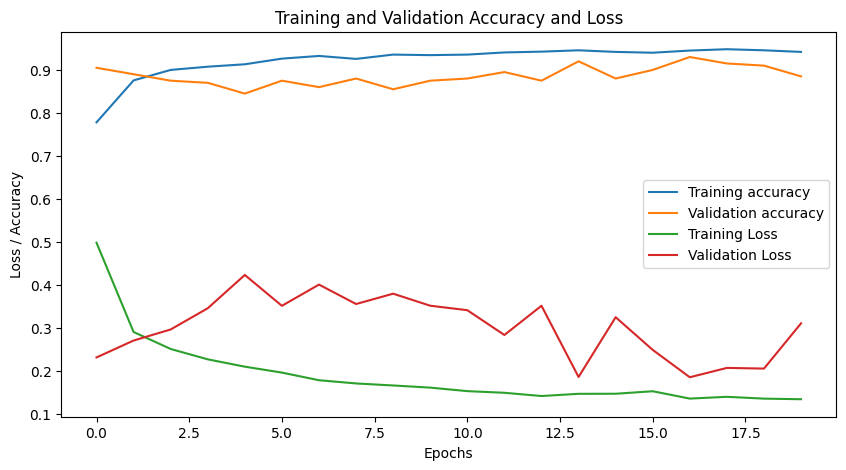

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.title('Training and Validation Accuracy and Loss')
plt.legend()
plt.show()

# Making predictions

In [24]:
predictions = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step


In [25]:
predictions = np.argmax(predictions, axis=1)

In [26]:
y_test = np.argmax(y_test_label, axis=1)

### Checking predictions accuracy

In [27]:
print(classification_report(y_test, predictions, target_names=le.classes_))


              precision    recall  f1-score   support

        High       0.95      0.98      0.96       112
         Low       0.63      1.00      0.78        31
    Moderate       0.94      0.58      0.72        57

    accuracy                           0.87       200
   macro avg       0.84      0.85      0.82       200
weighted avg       0.90      0.87      0.86       200



In [28]:
r2_score(y_test, predictions)

0.6750609260763607

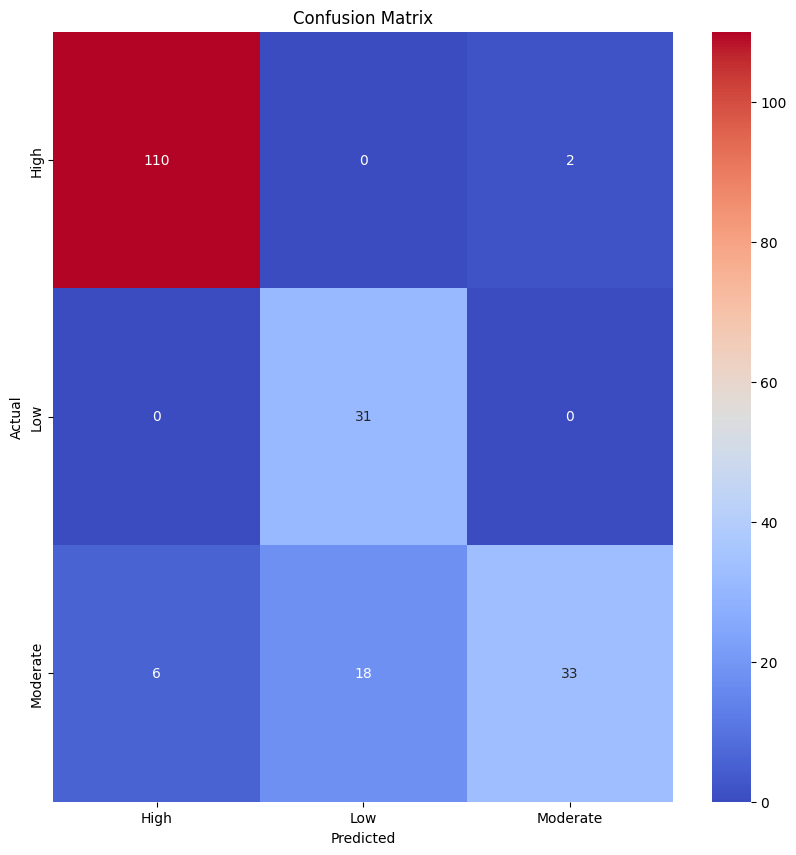

In [29]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Conclusion

This notebook demonstrates a comprehensive analysis of student stress levels using a variety of data science techniques. The dataset was downloaded, cleaned, and explored to understand the distribution and correlation of various features. TensorFlow Data Validation (TFDV) was utilized to generate statistics and identify anomalies. A neural network model was built and trained to predict stress levels, achieving reasonable accuracy. The results were visualized and evaluated using classification reports and confusion matrices, providing insights into the model's performance and areas for improvement.